# LAST Quick Start

## Target audience

This is a quick start guide for [LAST, the LAttice-based Speech Transducer library](https://github.com/google-research/last).
LAST is a JAX library, thus some knowledge about JAX and related libraries is always useful but is not required for understanding the core content of this notebook.

We strive to make this notebook as accessible as possible, so don't hesitate to [ask questions](https://github.com/google-research/last/issues/new) if there is anything that you don't understand!

## Outline

We will cover the following,
*   Installing LAST from `pip`
*   Building a simple speech recognition model using LAST
*   Training and evaluating our model using the [spoken digit](https://github.com/Jakobovski/free-spoken-digit-dataset) dataset

## Installing LAST

*   LAST can be installed with the command `pip install last-asr`.
*   If you are using GPU, first install the GPU-enabled version of JAX following the instructions [here](https://github.com/jax-ml/jax?tab=readme-ov-file#instructions). The version installed by pip by default may not have support for GPU.

In [ ]:
# For this notebook, we specifiy a version for stability. For actual
# installations, we recommend always using the latest version.
!pip install --quiet last-asr==0.0.4

## The JAX Ecosystem

Unlike TensorFlow or PyTorch, JAX does not aim to be a complete machine learning package. Common tasks in machine learning are often performed with other libraries in the ecosystem. Here's a list of what we will use in this notebook:
*   [Flax](https://flax-linen.readthedocs.io/en/latest/) provides basic building blocks of neural network models, akin to `tf.keras` or `torch.nn`.
*   [Optax](https://optax.readthedocs.io) provides optimizer implementations.
*   We are also using [TensorFlow Datasets](https://www.tensorflow.org/datasets) to load data. However, TensorFlow is only used for data preprocessing. In principle, any dataset frameworks that can return examples as NumPy arrays will work well with JAX.

In [ ]:
# pydub is also installed so that we can use the spoken digit dataset.
!pip install --quiet flax matplotlib optax pydub tensorflow tensorflow-datasets

In [ ]:
import functools
import pprint

import flax.linen as nn
import jax
import jax.numpy as jnp
import last
import matplotlib.pyplot as plt
import optax
import tensorflow as tf
# Disallow TensorFlow from using GPU so that it won't interfere with JAX.
tf.config.set_visible_devices([], 'GPU')
import tensorflow_datasets as tfds

from IPython import display

if not jax.devices('gpu'):
  raise RuntimeError('We recommend using a GPU to run this notebook')

## Example Task: Spoken Digit Classification

The [spoken digit](https://github.com/Jakobovski/free-spoken-digit-dataset) dataset consists of short audio clips of spoken English digits.

The audio is preprocessed into log-Mel-spectrograms following the standard practice in speech recognition.

While there are only 10 possible classes for this task, to mimic an actual speech recognition task, we train the model to spell out the letters of each number.

Below are some examples of the audio clips and their spectrograms.
The actual data preprocessing code in TensorFlow is not central to understanding the rest of the notebook and can be safely skipped when reading.

two


one


nine


nine


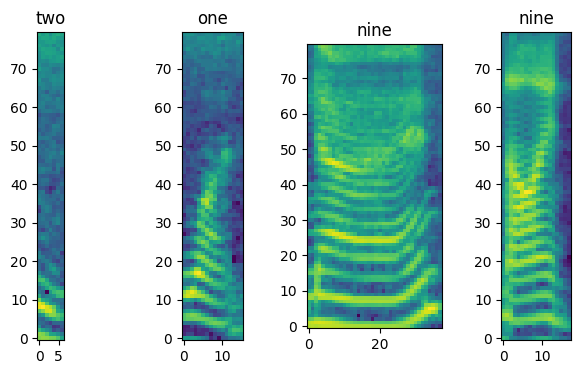

In [ ]:
# @title Data preprocessing code {display-mode: "form"}


def audio_frontend(
    audio: tf.Tensor, frame_length: int, frame_step: int, num_mel_bins: int
) -> tuple[tf.Tensor, tf.Tensor]:
  """Frontend for extracting features from audio.

  Args:
    audio: [num_samples] waveform.
    frame_length: The STFT window length. See frame_length in tf.signal.stft()
      for more details.
    frame_step: The STFT window step. See frame_step in tf.signal.stft() for
      more details.
    num_mel_bins: Number of bins to produce for the log-Mel-spectrogram. See
      num_mel_bins in tf.signal.linear_to_mel_weight_matrix() for more details.

  Returns:
    (log_mel, num_frames) tuple:
    -   log_mel: [num_frames, num_mel_bins] float32 log-Mel-spectrograms.
    -   num_frames: [] int32 length of the spectrograms.
  """
  spectrogram = tf.cast(
      tf.abs(tf.signal.stft(audio / 32768, frame_length, frame_step)),
      tf.float32,
  )
  num_frames = tf.cast(tf.shape(spectrogram)[0], tf.int32)
  mel = spectrogram @ tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins=num_mel_bins, num_spectrogram_bins=spectrogram.shape[-1]
  )
  log_mel = tf.maximum(-10.0, tf.math.log(mel))
  return log_mel, num_frames


def make_text_labels(int_label: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
  """Converts class labels into text.

  Args:
    int_label: [] int64 class label.

  Returns:
    (labels, num_labels) tuple:
    -   labels: [num_labels] int32 output labels, in the range of [1, 26],
    corresponding to letters "a" to "z".
    -   num_labels: [] int32 length of the output labels.
  """
  vocab = tf.constant([
      'zero',
      'one',
      'two',
      'three',
      'four',
      'five',
      'six',
      'seven',
      'eight',
      'nine',
  ])
  labels = tf.cast(
      tf.strings.unicode_decode(vocab[int_label], 'ascii') - ord('a') + 1,
      tf.int32,
  )
  num_labels = tf.cast(tf.shape(labels)[0], tf.int32)
  return labels, num_labels


def preprocess_example(example: dict[str, tf.Tensor]) -> dict[str, tf.Tensor]:
  log_mel, num_frames = audio_frontend(
      audio=example['audio'], frame_length=512, frame_step=160, num_mel_bins=80
  )
  labels, num_labels = make_text_labels(example['label'])
  return dict(
      log_mel=log_mel,
      num_frames=num_frames,
      labels=labels,
      num_labels=num_labels,
  )


def preprocess(
    dataset: tf.data.Dataset,
    is_train: bool = False,
    batch_size: int = 128,
    max_num_frames: int = 30,
    max_num_labels: int = 5,
) -> tf.data.Dataset:
  """Applies data preprocessing for training and evaluation."""
  # Preprocess individual examples.
  dataset = dataset.map(preprocess_example, num_parallel_calls=tf.data.AUTOTUNE)
  # Skip long examples to save time since this is an example notebook.
  dataset = dataset.filter(
      lambda example: example['num_frames'] <= max_num_frames
  )
  # Shuffle and repeat data for training.
  if is_train:
    dataset = dataset.shuffle(buffer_size=1000).repeat()
  # Pad and batch examples.
  dataset = dataset.padded_batch(
      batch_size,
      {
          'log_mel': [max_num_frames, None],
          'num_frames': [],
          'labels': [max_num_labels],
          'num_labels': [],
      },
  )
  return dataset


ALL_DATA = tfds.load('spoken_digit', split='train')


def display_examples(n: int = 4) -> None:
  # Draw log-mel-spectrograms.
  batch = next(
      ALL_DATA.map(preprocess_example).padded_batch(n).as_numpy_iterator()
  )
  texts = []
  log_mels = []
  for i in range(len(batch['num_frames'])):
    texts.append(
        ''.join(
            [
                chr(ord('a') - 1 + y)
                for y in batch['labels'][i, : batch['num_labels'][i]]
            ]
        )
    )
    log_mels.append(batch['log_mel'][i, : batch['num_frames'][i]])
  plt.figure(figsize=(len(texts) * 2, 4))
  for i, (text, log_mel) in enumerate(zip(texts, log_mels)):
    plt.subplot(1, len(texts), i + 1)
    plt.imshow(log_mel.T, origin='lower')
    plt.title(text)
  # Display audio.
  waveforms = ALL_DATA.map(lambda x: x['audio']).as_numpy_iterator()
  for text in texts:
    print(text)
    display.display(display.Audio(next(waveforms), rate=8000))


display_examples()

We will evaluate on a single batch from the first 1000 examples (980 actual examples after discarding examples that are too long), and train on the rest of the data.

From now on, we will no longer be using TensorFlow. The batches for training and evaluation are simply dicts of NumPy arrays with the following entries,
*   `log_mel`: `[batch_size, max_num_frames, 80]` float32 padded log-Mel-spectrograms.
*   `num_frames`: `[batch_size]` int32 length of the spectrograms.
*   `labels`: `[batch_size, max_num_labels]` int32 padded reference output labels in the range of [1, 26], corresponding to letters "a" to "z".
*   `num_labels`: `[batch_size]` int32 length of the reference outputs.

In [ ]:
# How many examples to take for creating the test batch.
TEST_BATCH_SPLIT = 1000
# A single test batch.
TEST_BATCH = next(
    ALL_DATA.take(TEST_BATCH_SPLIT)
    .apply(functools.partial(preprocess, batch_size=TEST_BATCH_SPLIT))
    .as_numpy_iterator()
)
# An iterator of training batches.
TRAIN_BATCHES = (
    ALL_DATA.skip(TEST_BATCH_SPLIT)
    .apply(functools.partial(preprocess, is_train=True))
    .prefetch(tf.data.AUTOTUNE)
    .as_numpy_iterator()
)
print('TEST_BATCH shape and dtype')
pprint.pprint(jax.tree.map(lambda x: (x.shape, x.dtype), TEST_BATCH))

TEST_BATCH shape and dtype
{'labels': ((980, 5), dtype('int32')),
 'log_mel': ((980, 30, 80), dtype('float32')),
 'num_frames': ((980,), dtype('int32')),
 'num_labels': ((980,), dtype('int32'))}


## A Simple Streaming Speech Recognition Model

To build a simple streaming speech recognition model, we need two pieces:
*   A unidirectional encoder that only looks at the left context. As an example, we will use a stack of LSTMs.
*   A decoder which is provided by `last.RecognitionLattice`. LAST allows us to train [GNAT](https://papers.neurips.cc/paper_files/paper/2022/file/1b4839ff1f843b6be059bd0e8437e975-Paper-Conference.pdf) models.

To build the encoder, we use two building blocks already available in Flax:
*   `nn.OptimizedLSTMCell` is an implementation of the [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs) cell. We will use two of its methods:
    *   `initialize_carry()` returns the initial hidden state for the LSTM.
    *   `__call__()` returns the new hidden state after consuming a single input.
*   `nn.scan` is a transformation that turns something consuming a single input such as `nn.OptimizeLSTMCell.__call__()` to something looping through a sequence of inputs.

In [ ]:
class Encoder(nn.Module):
  """A stack of unidirectional LSTMs."""

  hidden_size: int
  num_layers: int

  @nn.compact
  def __call__(self, xs):
    """Encodes the inputs.

    Args:
      xs: [batch_size, max_num_frames, feature_size] input sequences.

    Returns:
      [batch_size, max_num_frames, hidden_size] output sequences.
    """
    # Flax allows randomness in initializing the hidden state. However LSTM's
    # initial hidden state is deterministic, so we just need a dummy RNG here.
    dummy_rng = jax.random.PRNGKey(0)
    # A stack of num_layers LSTMs.
    for _ in range(self.num_layers):
      # nn.scan() when passed a class returns another class like object. Thus
      # nn.scan(nn.OptimizedLSTMCell, ...)() constructs such a new instance of
      # such a "class". Then, we invoke the __call__() method of this object
      # by passing (init_carry, xs).
      #
      # The __call__() method of the nn.scan()-transformed "class" loops through
      # the input whereas the original class takes one step.
      cell = nn.scan(
          nn.OptimizedLSTMCell,
          variable_broadcast='params',
          split_rngs={'params': False},
          in_axes=1,
          out_axes=1,
      )(self.hidden_size)
      init_carry = cell.initialize_carry(dummy_rng, xs[:, 0, :].shape)
      _, xs = cell(init_carry, xs)
    return xs

We directly create the decoder using `last.RecognitionLattice` inside the top level model.

Our model provides two functionalities:
-   `__call__()` takes in a batch and computes the loss value. The loss we will optimize is the log-loss, i.e. $E[-\log P(Y|X; \theta)]$ with $X$ being the input log-Mel-spectrogram and $Y$ be the reference label sequence.
-   `decode()` decodes a batch, returning the hypothesis alignment labels. Because we are using the frame-dependent alignment lattice here, for a length $T$ encoder embedding sequence, there are exact $T$ alignment labels in the output, which can be either 0 (blank) or 1 to 26 (letters).

To create a `last.RecognitionLattice`, we need to make a few decisions following [the modular framework in GNAT](https://papers.neurips.cc/paper_files/paper/2022/file/1b4839ff1f843b6be059bd0e8437e975-Paper-Conference.pdf):
-   Context dependency: A context dependency is a finite state automaton encoding the lexical (non-blank) output context. For the example below, we use a full $n$-gram context with a `context_size` defaulting to 2.
-   Alignment lattice: An alignment lattice determines how encoder frames and alignment labels align. We will use the frame-dependent alignment, i.e. each frame will correspond to exactly one label, which can be either blank or lexical.
-   Weight function: A weight function determines the weight of producing some label as the next output given the encoder frame and the context state. We will use the joint weight function, similar to the joint network in an RNN Transducer.

In [ ]:
class Model(nn.Module):
  # Whether to use a locally normalized model. We shall demonstrate the effect
  # of this in the experiments below.
  locally_normalize: bool = False
  # Size for encoder LSTMs, the output context LSTM, the joint weight function.
  hidden_size: int = 256
  num_encoder_layers: int = 1
  # As a convention, in LAST, we do not count the blank (0) label in the vocab.
  vocab_size: int = 26
  context_size: int = 2

  def setup(self):
    self.encoder = Encoder(
        hidden_size=self.hidden_size, num_layers=self.num_encoder_layers
    )

    # Encodes context states using an LSTM.
    def weight_fn_cacher_factory(context):
      assert isinstance(context, last.contexts.FullNGram)
      return last.weight_fns.SharedRNNCacher(
          vocab_size=context.vocab_size,
          context_size=context.context_size,
          rnn_size=self.hidden_size,
          rnn_embedding_size=self.hidden_size,
      )

    # Constructs the joint weight function.
    def weight_fn_factory(context):
      _, vocab_size = context.shape()
      weight_fn = last.weight_fns.JointWeightFn(
          vocab_size=vocab_size, hidden_size=self.hidden_size
      )
      if self.locally_normalize:
        weight_fn = last.weight_fns.LocallyNormalizedWeightFn(weight_fn)
      return weight_fn

    # Putting all pieces together to build the RecoginitionLattice.
    self.lattice = last.RecognitionLattice(
        context=last.contexts.FullNGram(
            vocab_size=self.vocab_size, context_size=self.context_size
        ),
        alignment=last.alignments.FrameDependent(),
        weight_fn_cacher_factory=weight_fn_cacher_factory,
        weight_fn_factory=weight_fn_factory,
    )

  def __call__(self, batch):
    """Scalar loss value."""
    features = self.encoder(batch['log_mel'])
    # The __call__() method of RecognitionLattice returns [batch_size] per-
    # example log-loss.
    return self.lattice(
        frames=features,
        num_frames=batch['num_frames'],
        labels=batch['labels'],
        num_labels=batch['num_labels'],
    ).mean()

  def decode(self, batch):
    """Decodes a batch into [batch_size, max_num_frames] alignment labels."""
    features = self.encoder(batch['log_mel'])
    return self.lattice.shortest_path(
        frames=features, num_frames=batch['num_frames']
    )[0]

To evaluate a trained model, we look at classification accuracy in addition to log-loss.
Because the returned hypothesis alignment labels contain blank labels, we need to first remove them before comparing against the reference.
In a more realistic speech recognition experiment, word error rate will typically be used instead.

In [ ]:
def remove_blank_labels(labels: jnp.ndarray) -> jnp.ndarray:
  """Removes blank labels by pushing lexical labels forward."""

  def remove_one(labels):
    padded_labels = jnp.pad(labels, [(1, 0)])
    indices = jnp.where(padded_labels, size=labels.shape[0])
    return padded_labels[indices]

  # remove_one() handles a single [num_labels] sequence. jax.vmap() transforms
  # that into a function that handles a [batch_size, num_labels] batch of
  # sequences.
  return jax.vmap(remove_one)(labels)


def sequence_accuracy(
    ref_labels: jnp.ndarray, hyp_labels: jnp.ndarray
) -> jnp.ndarray:
  """Accuracy computed with exact match."""
  hyp_labels = remove_blank_labels(hyp_labels)
  # Pad the sequences to the same shape for label-wise comparison.
  pad_length = max(ref_labels.shape[-1], hyp_labels.shape[-1])
  hyp_labels = jnp.pad(
      hyp_labels,
      [(0, 0), (0, pad_length - hyp_labels.shape[-1])],
  )
  ref_labels = jnp.pad(
      ref_labels,
      [(0, 0), (0, pad_length - ref_labels.shape[-1])],
  )
  exact_match = (hyp_labels == ref_labels).all(axis=-1)
  return exact_match.mean()

The actual experiment loop is fairly straight-forward.
1.  We use the AdamW optimizer.
1.  We randomly initialize the model parameters using a fixed RNG seed.
1.  We initialize the optimizer states according to the model parameters.
1.  Then we repeatedly run the training and evaluation steps and report our progress.

For more realistic applications, we often need to checkpoint our state (i.e. `params` and `opt_state` among other things).
A good library for checkpointing in JAX is [Orbax](https://github.com/google/orbax).

In [ ]:
def train_and_eval(
    test_batch,
    train_batches,
    model,
    optimizer=optax.adamw(1e-3),
    num_steps=1000,
    num_steps_per_eval=100,
):
  # Initialize the model parameters using a fixed RNG seed. Flax linen Modules
  # need to know the shape and dtype of its input to initialize the parameters,
  # we thus pass it the test batch.
  params = model.init(jax.random.PRNGKey(0), test_batch)
  opt_state = optimizer.init(params)

  # jax.jit compiles a JAX function to speed up execution.
  # `donate_argnums=(0, 1)` means we know that the input `params` and
  # `opt_state` won't be needed after calling `train_step`, so we donate them
  # and allow JAX to use their memory for storing the output.
  @functools.partial(jax.jit, donate_argnums=(0, 1))
  def train_step(params, opt_state, batch):
    # Compute the loss value and the gradients.
    loss, grads = jax.value_and_grad(model.apply)(params, batch)
    # Compute the actual updates based on the optimizer state and the gradients.
    updates, opt_state = optimizer.update(grads, opt_state, params)
    # Apply the updates.
    params = optax.apply_updates(params, updates)
    return params, opt_state, {'loss': loss}

  # We are not passing additional arguments to jax.jit, so it can be used
  # directly as a function decorator.
  @jax.jit
  def eval_step(params, batch):
    # Test loss.
    loss = model.apply(params, batch)
    # Test accuracy.
    hyp_labels = model.apply(params, batch, method=model.decode)
    accuracy = sequence_accuracy(batch['labels'], hyp_labels)
    return {'loss': loss, 'accuracy': accuracy}

  @jax.jit
  def jax_decode_step(params, batch):
    return model.apply(params, batch, method=model.decode)

  def decode_step(params, batch):
    # Only decode the first example.
    batch = jax.tree.map(lambda x: x[:1], batch)
    hyp_labels = jax.device_get(jax_decode_step(params, batch))
    ref_labels = batch['labels']

    def text(labels):
      return ''.join([chr(ord('a') - 1 + y) for y in labels[0] if y])

    print(f'\t\tref: {text(ref_labels)!r}, hyp: {text(hyp_labels)!r}')


  num_done_steps = 0
  while num_done_steps < num_steps:
    for _ in range(num_steps_per_eval):
      params, opt_state, train_metrics = train_step(
          params, opt_state, next(train_batches)
      )
    eval_metrics = eval_step(params, test_batch)
    num_done_steps += num_steps_per_eval
    print(f'step {num_done_steps}\teval {eval_metrics}\ttrain {train_metrics}')
    decode_step(params, test_batch)

We will train two models: one locally normalized and one globally normalized, to compare the effect of global normalization when the encoder only has left context.

This cell takes about 6 minutes when using a nVidia T4 GPU.

We can see that because the encoder only sees the left context, a globally normalized model is much more accurate (98.2% vs 94.7%) because it doesn't suffer from label bias.
The [GNAT](https://papers.neurips.cc/paper_files/paper/2022/file/1b4839ff1f843b6be059bd0e8437e975-Paper-Conference.pdf) paper discusses this in more details.

In [ ]:
for locally_normalize in [True, False]:
  model = Model(locally_normalize=locally_normalize)
  print(model)
  train_and_eval(TEST_BATCH, TRAIN_BATCHES, model)
  print(flush=True)

Model(
    # attributes
    locally_normalize = True
    hidden_size = 256
    num_encoder_layers = 1
    vocab_size = 26
    context_size = 2
)
step 100	eval {'accuracy': Array(0.79795915, dtype=float32), 'loss': Array(0.54083705, dtype=float32)}	train {'loss': Array(0.41135517, dtype=float32)}
		ref: 'two', hyp: 'two'
step 200	eval {'accuracy': Array(0.9204081, dtype=float32), 'loss': Array(0.23098816, dtype=float32)}	train {'loss': Array(0.06813797, dtype=float32)}
		ref: 'two', hyp: 'two'
step 300	eval {'accuracy': Array(0.932653, dtype=float32), 'loss': Array(0.18907069, dtype=float32)}	train {'loss': Array(0.02083038, dtype=float32)}
		ref: 'two', hyp: 'two'
step 400	eval {'accuracy': Array(0.93775505, dtype=float32), 'loss': Array(0.18539642, dtype=float32)}	train {'loss': Array(0.0055441, dtype=float32)}
		ref: 'two', hyp: 'two'
step 500	eval {'accuracy': Array(0.9438775, dtype=float32), 'loss': Array(0.18252018, dtype=float32)}	train {'loss': Array(0.00498704, dtype=float32)}


## Next Steps

If you are new to JAX, we recommend checking out the following guides,
*   [JAX Quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)
*   [Flax Basics](https://flax-linen.readthedocs.io/en/latest/guides/flax_fundamentals/flax_basics.html)
*   [Optax Getting Started](https://optax.readthedocs.io/en/latest/getting_started.html)
*   [Checkpointing with Orbax](https://orbax.readthedocs.io/en/latest/guides/checkpoint/orbax_checkpoint_101.html)

The complete LAST documentation is available on https://last-asr.readthedocs.io.

Finally, please don't hesitate to [ask questions](https://github.com/google-research/last/issues/new) whenever you run into problems with this notebook or LAST in general.